# 은행 고객 예금 가입 예측: 완전 분석 교안 (고급판 + 불균형 처리)
데이터: `bank-additional-full.csv`
작성시각: 2025-10-29 07:19

이 노트북은 '신규 예금상품에 가입할 고객을 예측'하는 전체 데이터 분석 흐름(EDA → 전처리 → 데이터 불균형 처리 → 모델링 → 평가 → 리포트)을 전부 다룹니다.

또한,
- `duration`이 주는 데이터 누수(leakage) 문제
- 소수 클래스(가입 고객)의 데이터 불균형을 완화하기 위한 Over/Under Sampling
까지 포함합니다.


## 1. 문제 정의 / 비즈니스 맥락

- 은행이 텔레마케팅(전화 캠페인)으로 정기예금 상품을 판매하려고 한다.
- 타깃: `y` = 'yes'이면 가입 성공 고객.
- 현실적으로 'yes'(성공)는 소수 클래스라서 불균형 데이터다.
- 콜 인력/시간은 비싸므로 '가입 가능성이 높은 고객'을 우선 콜해야 한다.
- 그래서 단순 정확도보다 '양성(yes)를 잘 포착하는 능력', 즉 재현율/정밀도 균형이 중요하다.


## 2. 데이터 로드 & 개요

In [16]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# 불균형 처리용
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

df = pd.read_csv("./data/10_bank-additional-full.csv", sep=';')
print("shape:", df.shape)
display(df.head())

print(df.info())
display(df.describe(include='all').T)


shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,41188.0,NaN,NaN,NaN,40.02406,10.42125,17.0,32.0,38.0,47.0,98.0
job,41188,12,admin.,10422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,41188,4,married,24928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,41188,8,university.degree,12168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,41188,3,no,32588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,41188,3,yes,21576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,41188,3,no,33950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,41188,2,cellular,26144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,41188,10,may,13769,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,41188,5,thu,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. 품질 점검 (결측치 / 중복 / 특이값)

결측치 개수:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64
중복행 수: 12
y count:
 y
no     36548
yes     4640
Name: count, dtype: int64
y ratio:
 y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64


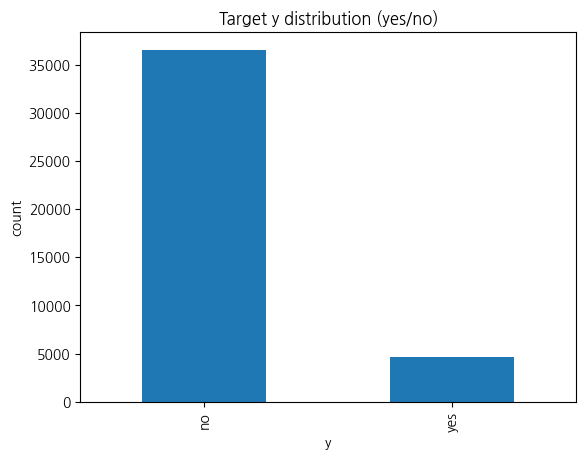

pdays value counts (상위):
pdays
999    39673
3        439
6        412
4        118
9         64
Name: count, dtype: int64
duration describe:
count    41188.000000
mean       258.285010
std        259.279249
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64


In [17]:

na_counts = df.isna().sum().sort_values(ascending=False)
print("결측치 개수:")
print(na_counts)

dup_count = df.duplicated().sum()
print("중복행 수:", dup_count)

y_counts = df['y'].value_counts()
y_ratio = df['y'].value_counts(normalize=True)
print("y count:\n", y_counts)
print("y ratio:\n", y_ratio)

plt.figure()
y_counts.plot(kind='bar')
plt.title("Target y distribution (yes/no)")
plt.xlabel("y")
plt.ylabel("count")
plt.show()

print("pdays value counts (상위):")
print(df['pdays'].value_counts().head())

print("duration describe:")
print(df['duration'].describe())


## 4. EDA

### 4.1 숫자형/범주형 컬럼 자동 분리

In [18]:

def get_numeric_columns(dataframe):
    return dataframe.select_dtypes(include='number').columns.tolist()

def get_categorical_columns(dataframe):
    return dataframe.select_dtypes(exclude='number').columns.tolist()

numeric_cols = get_numeric_columns(df)
categorical_cols = get_categorical_columns(df)

print("numeric_cols:", numeric_cols)
print("categorical_cols:", categorical_cols)


numeric_cols: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
categorical_cols: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


### 4.2 수치형 분포

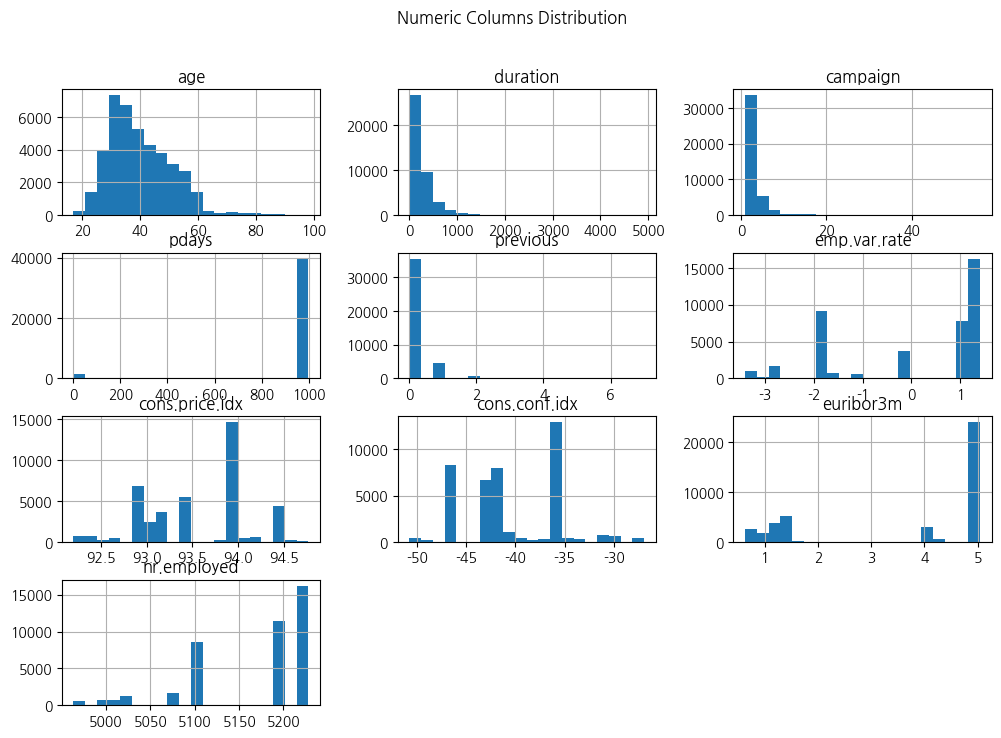

In [19]:

df[numeric_cols].hist(figsize=(12,8), bins=20)
plt.suptitle("Numeric Columns Distribution")
plt.show()


### 4.3 범주형 분포 / y별 비교

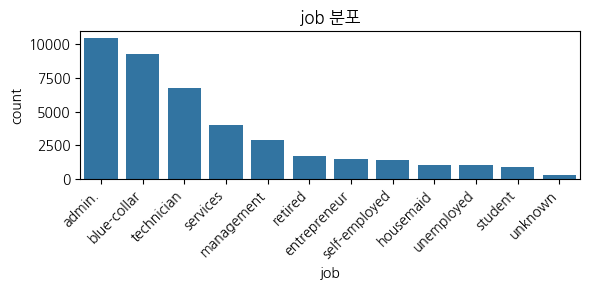

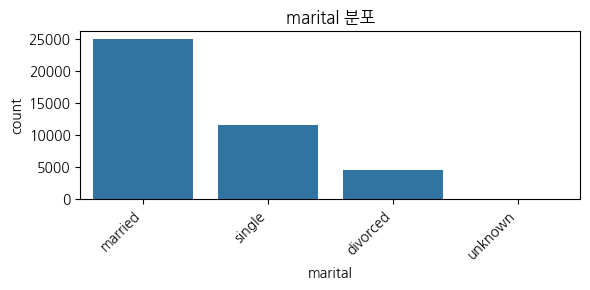

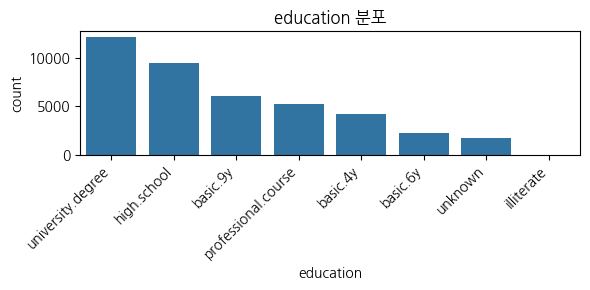

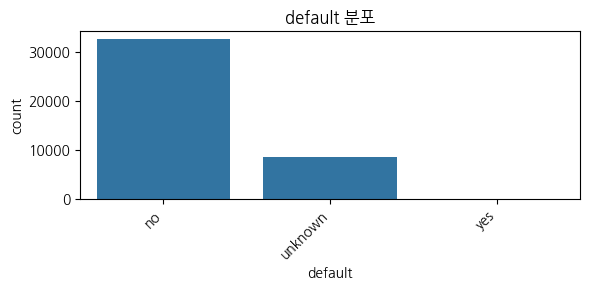

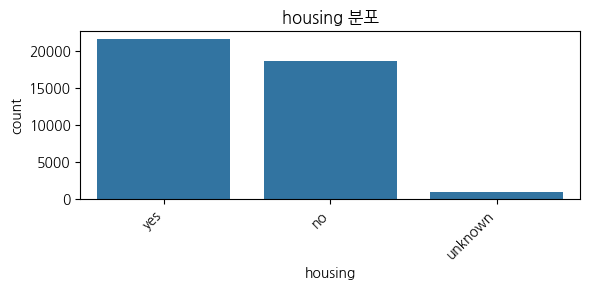

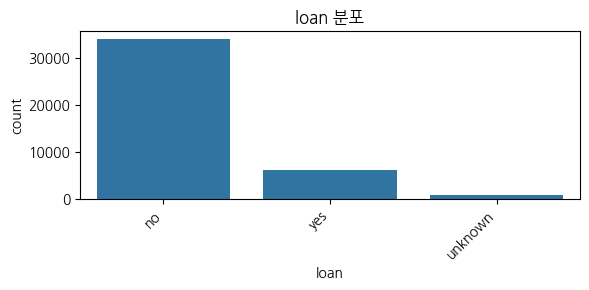

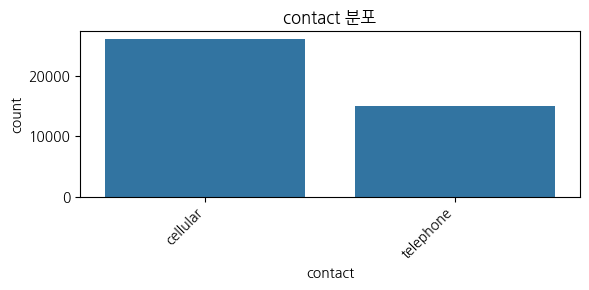

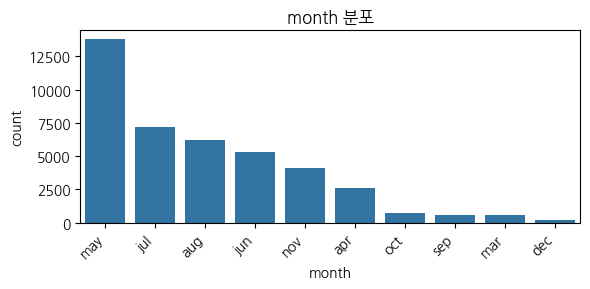

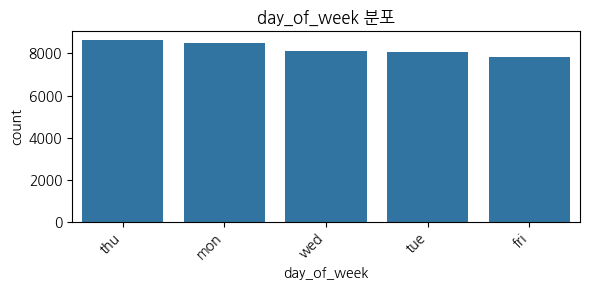

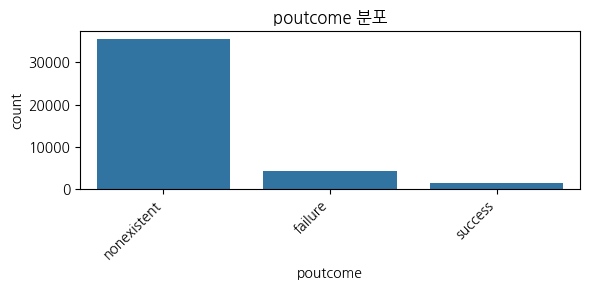

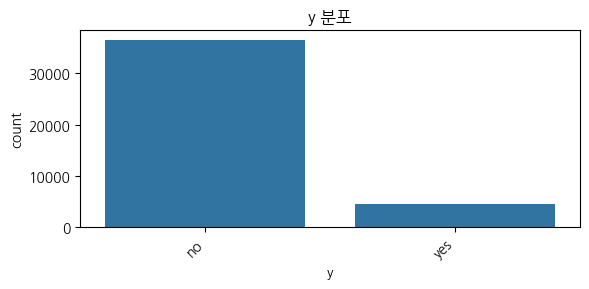

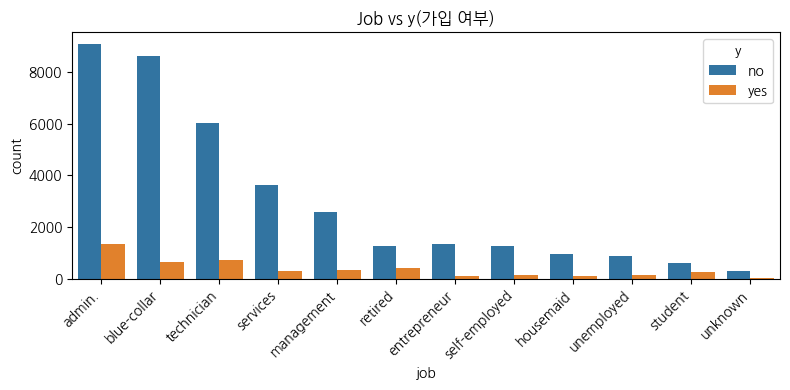

In [20]:

for col in categorical_cols:
    plt.figure(figsize=(6,3))
    order = df[col].value_counts().index
    sns.countplot(x=col, data=df, order=order)
    plt.title(f"{col} 분포")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(8,4))
order = df['job'].value_counts().index
sns.countplot(x='job', hue='y', data=df, order=order)
plt.title("Job vs y(가입 여부)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 4.4 y와 연속형 변수 관계

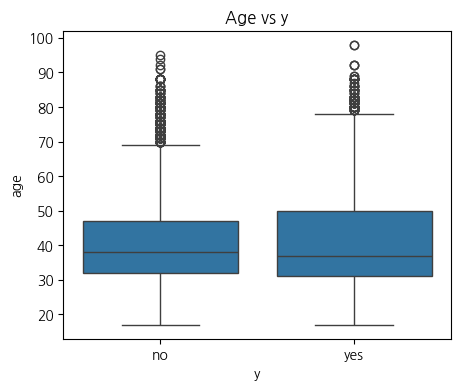

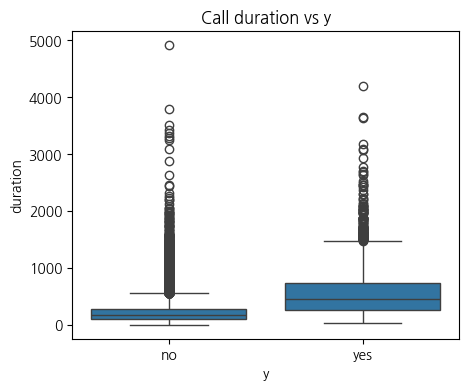

In [21]:

plt.figure(figsize=(5,4))
sns.boxplot(x='y', y='age', data=df)
plt.title("Age vs y")
plt.show()

plt.figure(figsize=(5,4))
sns.boxplot(x='y', y='duration', data=df)
plt.title("Call duration vs y")
plt.show()


### 4.5 상관관계 Heatmap

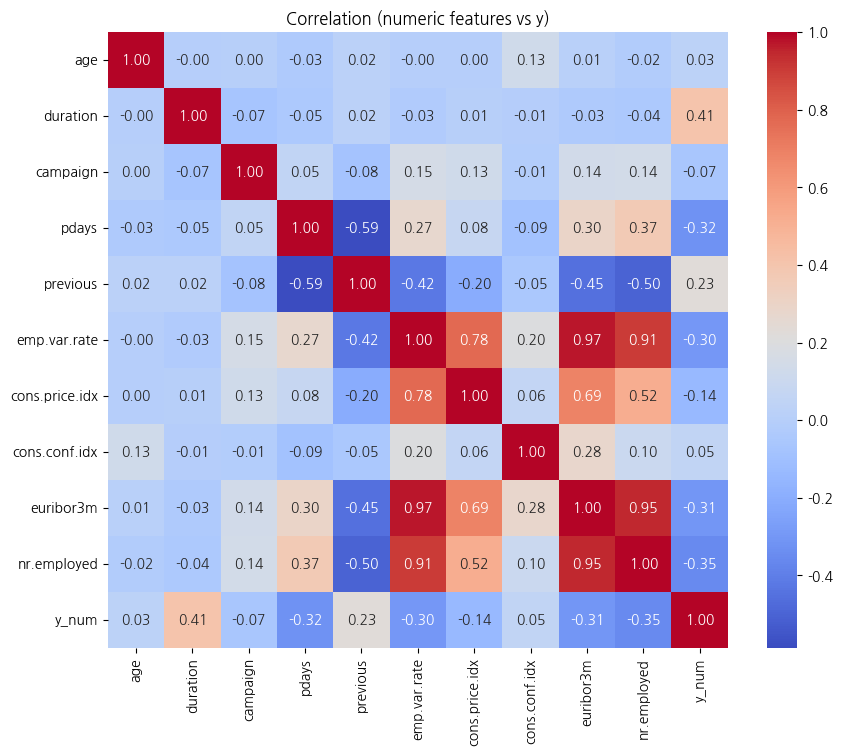

In [22]:

df_corr = df.copy()
df_corr['y_num'] = df_corr['y'].map({'no':0,'yes':1})
corr_mat = df_corr[numeric_cols + ['y_num']].corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation (numeric features vs y)")
plt.show()


## 5. 전처리 + 파생변수 + 인코딩

In [23]:

# 타깃 인코딩
y = df['y'].map({'no':0, 'yes':1})

# 특징행렬
X_full = df.drop(columns=['y']).copy()

# 비즈니스 룰 기반 파생변수:
# pdays==999 은 '이전 캠페인에서 연락한 적 없음'을 의미하므로 플래그화
X_full['no_prev_contact'] = (X_full['pdays'] == 999).astype(int)

# duration 은 통화 후에만 알 수 있으므로 실제 사전예측에서는 쓸 수 없다.
# 비교를 위해 duration 없는 버전도 준비
X_nodur = X_full.drop(columns=['duration'])

# 원-핫 인코딩
X_full_enc = pd.get_dummies(X_full, drop_first=True)
X_nodur_enc = pd.get_dummies(X_nodur, drop_first=True)

print("with duration:", X_full_enc.shape)
print("without duration:", X_nodur_enc.shape)

# 데이터 분할(동일한 stratify=y)
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_full_enc, y, test_size=0.2, random_state=42, stratify=y
)
Xn_train, Xn_test, yn_train, yn_test = train_test_split(
    X_nodur_enc, y, test_size=0.2, random_state=42, stratify=y
)

print("FULL Train/Test:", Xf_train.shape, Xf_test.shape)
print("NODUR Train/Test:", Xn_train.shape, Xn_test.shape)

# 표준화(스케일링)는 로지스틱 회귀용으로 숫자형 컬럼에만 적용
scaler_full = StandardScaler()
num_full_cols = Xf_train.select_dtypes(include='number').columns.tolist()
Xf_train_scaled = Xf_train.copy()
Xf_test_scaled = Xf_test.copy()
Xf_train_scaled[num_full_cols] = scaler_full.fit_transform(Xf_train[num_full_cols])
Xf_test_scaled[num_full_cols] = scaler_full.transform(Xf_test[num_full_cols])

scaler_nodur = StandardScaler()
num_nodur_cols = Xn_train.select_dtypes(include='number').columns.tolist()
Xn_train_scaled = Xn_train.copy()
Xn_test_scaled = Xn_test.copy()
Xn_train_scaled[num_nodur_cols] = scaler_nodur.fit_transform(Xn_train[num_nodur_cols])
Xn_test_scaled[num_nodur_cols] = scaler_nodur.transform(Xn_test[num_nodur_cols])


with duration: (41188, 54)
without duration: (41188, 53)
FULL Train/Test: (32950, 54) (8238, 54)
NODUR Train/Test: (32950, 53) (8238, 53)


### duration은 왜 누수인가?
- `duration`은 실제로 전화를 건 뒤 통화가 얼마나 오래 지속되었는지를 의미한다.
- 즉, 통화가 끝난 다음에만 알 수 있는 '사후 정보'다.
- 그런데 이 값을 학습 입력으로 넣으면 모델은 '미래 정보를 미리 본 것'처럼 부정확하게 유리해진다.
- 이걸 데이터 누수(data leakage)라고 하며, 실제 배포 모델(콜 대상 사전추천)에는 `duration`을 넣으면 안 된다.


## 6. 데이터 불균형 처리 (Over/Under Sampling)
타깃 `y`에서 'yes' 비율은 매우 낮다. 이건 대부분의 분류기가 다수 클래스('no')에 치우쳐 예측하게 만든다.

대표적인 전략:
1. Over-sampling (소수 클래스 복제/합성)
   - RandomOverSampler: 적은 쪽을 단순 복제
   - SMOTE: 적은 쪽 샘플 사이에서 새로운 합성 샘플을 만들어냄
2. Under-sampling (다수 클래스 줄이기)
   - RandomUnderSampler: 많은 쪽을 랜덤하게 덜어내기
3. class_weight 조정
   - 분류기의 손실 함수에서 소수 클래스를 더 크게 가중치 줌
   - LogisticRegression(class_weight='balanced'), RandomForestClassifier(class_weight='balanced_subsample') 등

이 노트북에서는 SMOTE(Over-sampling)와 RandomUnderSampler(Under-sampling)를 실제로 적용해본 후 성능을 비교한다.


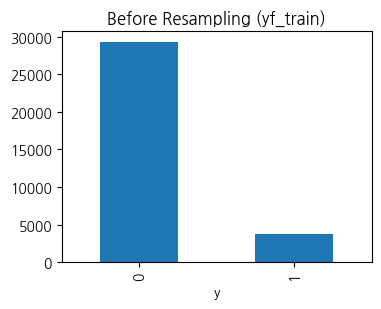

After RandomOverSampler: y
0    29238
1    29238
Name: count, dtype: int64
After SMOTE: y
0    29238
1    29238
Name: count, dtype: int64
After RandomUnderSampler: y
0    3712
1    3712
Name: count, dtype: int64


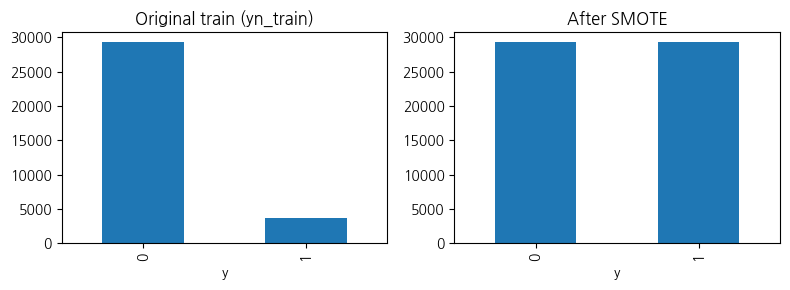

In [24]:

# 불균형 전 분포 시각화
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(4,3))
yf_train.value_counts().plot(kind='bar', ax=ax, title='Before Resampling (yf_train)')
plt.show()

# 6.1 RandomOverSampler (단순 Over-sampling)
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(Xn_train, yn_train)  # duration 제외 버전으로 예시
print("After RandomOverSampler:", pd.Series(y_ros).value_counts())

# 6.2 SMOTE (합성 샘플로 Over-sampling)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(Xn_train, yn_train)
print("After SMOTE:", pd.Series(y_smote).value_counts())

# 6.3 RandomUnderSampler (다수 클래스 줄이기)
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(Xn_train, yn_train)
print("After RandomUnderSampler:", pd.Series(y_rus).value_counts())

# 시각적으로 비교 (원본 vs SMOTE 예시)
fig, ax = plt.subplots(1,2, figsize=(8,3))
yn_train.value_counts().plot(kind='bar', ax=ax[0], title='Original train (yn_train)')
y_smote.value_counts().plot(kind='bar', ax=ax[1], title='After SMOTE')
plt.tight_layout()
plt.show()


## 7. 모델 학습: duration 포함 vs 제외 / 불균형 반영

In [25]:

# 7.1 LogisticRegression WITH duration (scaled)
log_full = LogisticRegression(max_iter=1000, class_weight='balanced')
log_full.fit(Xf_train_scaled, yf_train)
ypred_log_full = log_full.predict(Xf_test_scaled)
yprob_log_full = log_full.predict_proba(Xf_test_scaled)[:,1]

# 7.2 LogisticRegression WITHOUT duration (scaled)
log_nodur = LogisticRegression(max_iter=1000, class_weight='balanced')
log_nodur.fit(Xn_train_scaled, yn_train)
ypred_log_nodur = log_nodur.predict(Xn_test_scaled)
yprob_log_nodur = log_nodur.predict_proba(Xn_test_scaled)[:,1]

# 7.3 LogisticRegression WITHOUT duration + SMOTE (scaled)
#    SMOTE로 증폭한 데이터를 다시 스케일링해야 공정 비교 가능
#    (주의: 스케일러는 원래 train 기준. 여기서는 간단 데모라 다시 학습형식으로만 비교)
scaler_smote = StandardScaler()
num_cols_smote = X_smote.select_dtypes(include='number').columns.tolist()
X_smote_scaled = X_smote.copy()
Xn_test_scaled_smote = Xn_test.copy()  # test는 원래의 테스트
X_smote_scaled[num_cols_smote] = scaler_smote.fit_transform(X_smote[num_cols_smote])
Xn_test_scaled_smote[num_cols_smote] = scaler_smote.transform(Xn_test[num_cols_smote])

log_smote = LogisticRegression(max_iter=1000, class_weight='balanced')
log_smote.fit(X_smote_scaled, y_smote)
ypred_log_smote = log_smote.predict(Xn_test_scaled_smote)
yprob_log_smote = log_smote.predict_proba(Xn_test_scaled_smote)[:,1]

# 7.4 RandomForest WITHOUT duration (no scaling needed)
rf_nodur = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced_subsample'
)
rf_nodur.fit(Xn_train, yn_train)
ypred_rf_nodur = rf_nodur.predict(Xn_test)
yprob_rf_nodur = rf_nodur.predict_proba(Xn_test)[:,1]


In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

######################################
# 7.x.1 Logistic Regression 튜닝
#  - 데이터: duration 제거 + SMOTE + 스케일링 버전 사용 (X_smote_scaled, y_smote)
#  - 이유: duration은 누수니까 실제 운영 후보 모델은 "NO duration" 계열이 타당
######################################

log_param_dist = {
    # C: 규제 강도의 역수 -> 클수록 규제가 약해짐
    "C": uniform(loc=0.001, scale=10),  # 0.001 ~ 10 사이 연속값
    # penalty / solver 조합은 L2 + lbfgs로 단순화 (수업용)
    # class_weight는 불균형 문제이므로 'balanced' 고정 유지
}

log_search = RandomizedSearchCV(
    estimator=LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        penalty='l2',
        solver='lbfgs'
    ),
    param_distributions=log_param_dist,
    n_iter=20,              # 시도 횟수 (수업에서 너무 크지 않게)
    scoring='roc_auc',      # 불균형일 땐 accuracy보다 AUC가 더 낫다
    cv=3,                   # 3-fold CV
    random_state=42,
    n_jobs=-1
)

log_search.fit(X_smote_scaled, y_smote)

print("=== LogisticRegression RandomizedSearchCV 결과 ===")
print("best params:", log_search.best_params_)
print("best CV score (AUC):", log_search.best_score_)

log_best = log_search.best_estimator_

# 테스트셋(Xn_test_scaled_smote / yn_test)에 대해 예측
ypred_log_best = log_best.predict(Xn_test_scaled_smote)
yprob_log_best = log_best.predict_proba(Xn_test_scaled_smote)[:, 1]

auc_log_best = roc_auc_score(yn_test, yprob_log_best)
print("Test ROC-AUC (best logistic):", auc_log_best)

######################################
# 7.x.2 RandomForest 튜닝
#   - 데이터: duration 제거 버전 (Xn_train, yn_train)
#   - 비교 대상: rf_nodur, rf_smote
#   - 여기서는 NO duration + SMOTE 데이터(X_smote, y_smote)로도 튜닝 가능
#     → 실제로는 불균형 개선된 쪽을 튜닝하는 게 자연스러워서 X_smote / y_smote에 맞춰줄 수 있음.
######################################

rf_param_dist = {
    "n_estimators": randint(100, 600),          # 트리 개수
    "max_depth": randint(3, 20),                # 트리 최대 깊이
    "min_samples_split": randint(2, 20),        # 노드 분할 최소 샘플 수
    "min_samples_leaf": randint(1, 20),         # 리프 최소 샘플 수
    "max_features": ["sqrt", "log2", None],     # 분할시 고려 feature 수
    # class_weight는 불균형용으로 balanced_subsample 혹은 None 비교
    "class_weight": ["balanced_subsample", None]
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        random_state=42
    ),
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring='roc_auc',   # 마찬가지로 AUC 중심
    cv=3,
    random_state=42,
    n_jobs=-1
)

# 랜덤포레스트는 스케일 필요 없음
# 둘 중 어떤 데이터를 쓸지 선택할 수 있음:
# - 원본 불균형 데이터(Xn_train, yn_train)
# - SMOTE로 증폭된 데이터(X_smote, y_smote)
# 실제 캠페인용 recall 향상을 비교하려면 SMOTE 쪽 튜닝이 실용적이라 아래는 그 버전으로 함
rf_search.fit(X_smote, y_smote)

print("=== RandomForest RandomizedSearchCV 결과 ===")
print("best params:", rf_search.best_params_)
print("best CV score (AUC):", rf_search.best_score_)

rf_best = rf_search.best_estimator_

# 테스트셋 예측 (원래의 holdout: Xn_test / yn_test)
ypred_rf_best = rf_best.predict(Xn_test)
yprob_rf_best = rf_best.predict_proba(Xn_test)[:, 1]

auc_rf_best = roc_auc_score(yn_test, yprob_rf_best)
print("Test ROC-AUC (best RF):", auc_rf_best)


=== LogisticRegression RandomizedSearchCV 결과 ===
best params: {'C': np.float64(0.20684494295802447)}
best CV score (AUC): 0.9189941003998308
Test ROC-AUC (best logistic): 0.7374167855795085
=== RandomForest RandomizedSearchCV 결과 ===
best params: {'class_weight': 'balanced_subsample', 'max_depth': 18, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 15, 'n_estimators': 314}
best CV score (AUC): 0.9619087038003823
Test ROC-AUC (best RF): 0.7841759929713665


## 8. 평가 / 비교

=== LogReg WITH duration (baseline) ===
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7310
           1       0.45      0.91      0.60       928

    accuracy                           0.87      8238
   macro avg       0.72      0.89      0.76      8238
weighted avg       0.93      0.87      0.88      8238

ROC-AUC: 0.9437958453228925
=== LogReg NO duration (baseline) ===
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      7310
           1       0.37      0.64      0.47       928

    accuracy                           0.83      8238
   macro avg       0.66      0.75      0.69      8238
weighted avg       0.88      0.83      0.85      8238

ROC-AUC: 0.8008755572196802
=== LogReg NO duration + SMOTE (baseline) ===
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      7310
           1       0.35      0.42      0.38       928

  

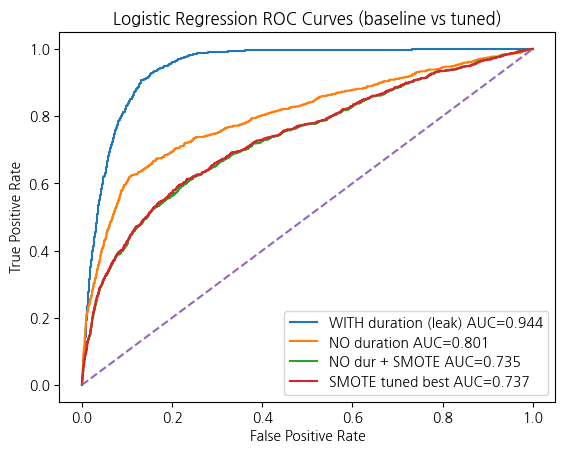

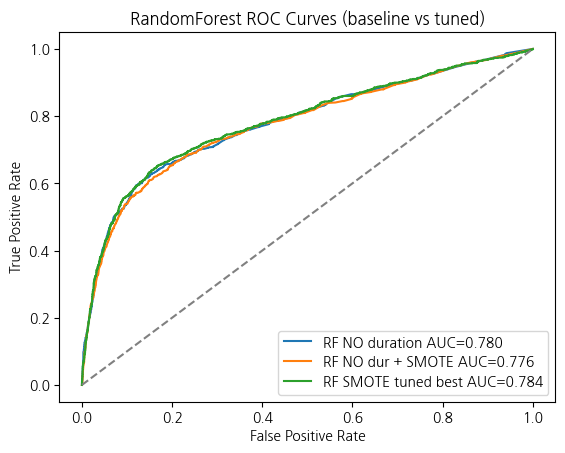

In [30]:

def report_and_auc(y_true, y_pred, y_prob, label):
    print(f"=== {label} ===")
    print(classification_report(y_true, y_pred))
    auc_val = roc_auc_score(y_true, y_prob)
    print("ROC-AUC:", auc_val)
    return auc_val

# 기존 로지스틱 3종
auc_log_full   = report_and_auc(yf_test, ypred_log_full,   yprob_log_full,   "LogReg WITH duration (baseline)")
auc_log_nodur  = report_and_auc(yn_test, ypred_log_nodur,  yprob_log_nodur,  "LogReg NO duration (baseline)")
auc_log_smote  = report_and_auc(yn_test, ypred_log_smote,  yprob_log_smote,  "LogReg NO duration + SMOTE (baseline)")

# 기존 랜덤포레스트 2종
auc_rf_nodur   = report_and_auc(yn_test, ypred_rf_nodur,   yprob_rf_nodur,   "RF NO duration (baseline)")

# RF with SMOTE (baseline)
auc_rf_smote   = report_and_auc(yn_test, ypred_rf_smote,   yprob_rf_smote,   "RF NO duration + SMOTE (baseline)")

# ✅ 튜닝된 (RandomizedSearchCV) 베스트 로지스틱
auc_log_best   = report_and_auc(yn_test, ypred_log_best,   yprob_log_best,   "LogReg (SMOTE tuned best)")

# ✅ 튜닝된 (RandomizedSearchCV) 베스트 랜덤포레스트
auc_rf_best    = report_and_auc(yn_test, ypred_rf_best,    yprob_rf_best,    "RF (SMOTE tuned best)")

fpr_full,   tpr_full,   _ = roc_curve(yf_test, yprob_log_full)
fpr_nodur,  tpr_nodur,  _ = roc_curve(yn_test, yprob_log_nodur)
fpr_smote,  tpr_smote,  _ = roc_curve(yn_test, yprob_log_smote)
fpr_best_l, tpr_best_l, _ = roc_curve(yn_test, yprob_log_best)  # 튜닝 로지스틱

plt.figure()
plt.plot(fpr_full,   tpr_full,   label=f'WITH duration (leak) AUC={auc_log_full:.3f}')
plt.plot(fpr_nodur,  tpr_nodur,  label=f'NO duration AUC={auc_log_nodur:.3f}')
plt.plot(fpr_smote,  tpr_smote,  label=f'NO dur + SMOTE AUC={auc_log_smote:.3f}')
plt.plot(fpr_best_l, tpr_best_l, label=f'SMOTE tuned best AUC={auc_log_best:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curves (baseline vs tuned)")
plt.legend()
plt.show()

fpr_rf_nodur,  tpr_rf_nodur,  _ = roc_curve(yn_test, yprob_rf_nodur)
fpr_rf_smote,  tpr_rf_smote,  _ = roc_curve(yn_test, yprob_rf_smote)
fpr_rf_best,   tpr_rf_best,   _ = roc_curve(yn_test, yprob_rf_best)  # 튜닝 RF

plt.figure()
plt.plot(fpr_rf_nodur, tpr_rf_nodur, label=f'RF NO duration AUC={auc_rf_nodur:.3f}')
plt.plot(fpr_rf_smote, tpr_rf_smote, label=f'RF NO dur + SMOTE AUC={auc_rf_smote:.3f}')
plt.plot(fpr_rf_best,  tpr_rf_best,  label=f'RF SMOTE tuned best AUC={auc_rf_best:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("RandomForest ROC Curves (baseline vs tuned)")
plt.legend()
plt.show()


In [31]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

results = pd.DataFrame({
    "Algorithm": [
        "Logistic Regression",
        "Logistic Regression",
        "Logistic Regression",
        "Logistic Regression",
        "Random Forest",
        "Random Forest",
        "Random Forest"
    ],
    "Model": [
        "LogReg WITH duration (leak baseline)",
        "LogReg NO duration (baseline)",
        "LogReg NO duration + SMOTE (baseline)",
        "LogReg SMOTE tuned best",
        "RF NO duration (baseline)",
        "RF NO duration + SMOTE (baseline)",
        "RF SMOTE tuned best"
    ],
    "ROC-AUC": [
        auc_log_full,
        auc_log_nodur,
        auc_log_smote,
        auc_log_best,
        auc_rf_nodur,
        auc_rf_smote,
        auc_rf_best
    ],
    "Precision": [
        precision_score(yf_test, ypred_log_full),
        precision_score(yn_test, ypred_log_nodur),
        precision_score(yn_test, ypred_log_smote),
        precision_score(yn_test, ypred_log_best),
        precision_score(yn_test, ypred_rf_nodur),
        precision_score(yn_test, ypred_rf_smote),
        precision_score(yn_test, ypred_rf_best)
    ],
    "Recall": [
        recall_score(yf_test, ypred_log_full),
        recall_score(yn_test, ypred_log_nodur),
        recall_score(yn_test, ypred_log_smote),
        recall_score(yn_test, ypred_log_best),
        recall_score(yn_test, ypred_rf_nodur),
        recall_score(yn_test, ypred_rf_smote),
        recall_score(yn_test, ypred_rf_best)
    ],
    "F1-score": [
        f1_score(yf_test, ypred_log_full),
        f1_score(yn_test, ypred_log_nodur),
        f1_score(yn_test, ypred_log_smote),
        f1_score(yn_test, ypred_log_best),
        f1_score(yn_test, ypred_rf_nodur),
        f1_score(yn_test, ypred_rf_smote),
        f1_score(yn_test, ypred_rf_best)
    ]
})

display(
    results.style.format({
        "ROC-AUC": "{:.3f}",
        "Precision": "{:.3f}",
        "Recall": "{:.3f}",
        "F1-score": "{:.3f}",
    }).set_caption("📊 Baseline vs SMOTE vs Tuned Best (LogReg first, RF after)")
)


,Algorithm,Model,ROC-AUC,Precision,Recall,F1-score
0,Logistic Regression,LogReg WITH duration (leak baseline),0.944,0.451,0.912,0.603
1,Logistic Regression,LogReg NO duration (baseline),0.801,0.367,0.644,0.468
2,Logistic Regression,LogReg NO duration + SMOTE (baseline),0.735,0.347,0.417,0.379
3,Logistic Regression,LogReg SMOTE tuned best,0.737,0.351,0.427,0.385
4,Random Forest,RF NO duration (baseline),0.780,0.573,0.287,0.382
5,Random Forest,RF NO duration + SMOTE (baseline),0.776,0.492,0.411,0.448
6,Random Forest,RF SMOTE tuned best,0.784,0.488,0.469,0.478


## 9. 리포트용 인사이트 / 결론

- `duration`을 넣은 모델은 AUC가 높게 나올 수 있지만, 그건 미래 정보를 미리 본 것이므로 실제 운영(콜 대상 선정)에는 쓸 수 없다. 이는 전형적인 데이터 누수(leakage)다.
- 데이터 불균형이 심하므로 accuracy만으로는 모델을 평가하면 안 된다. 소수 클래스(가입 고객)의 recall, precision, f1-score, 그리고 ROC-AUC/PR-AUC 등을 함께 봐야 한다.
- Over-sampling(SMOTE 등)을 적용하면 소수 클래스에 대한 재현율을 개선할 수 있으나, 과적합 위험도 증가할 수 있다. Under-sampling은 다수 클래스를 줄여 학습을 단순화하지만 정보 손실이 크다.
- class_weight='balanced' 같은 가중치 조정은 별도의 데이터 증폭 없이도 불균형을 완화하는 실무적으로 매우 간편한 방법이다.
- 최종적으로 마케팅 KPI(콜 인력 비용, 콜 성공률, 고객 반응 리스크 등)에 따라 precision을 우선할지 recall을 우선할지 결정해야 한다. 예: '고객을 놓치지 않는 것'이 더 중요하다면 recall을, '헛콜을 줄이는 것'이 더 중요하다면 precision을 우선 지표로 삼을 수 있다.
